In [17]:
import ReplayBuffer

In [18]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import os
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import pandas as pd
%matplotlib inline

In [19]:
err_treshold = .1

In [20]:
cmap=plt.cm.jet
z_cmap = plt.cm.viridis

In [21]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=err_treshold)
z_norm = matplotlib.colors.Normalize(vmin=0.25, vmax=0.5)

In [22]:
taget_points = np.loadtxt('../src/test_points.txt')
optim = pd.read_csv('../runs/test_optim.csv',header=0)
optim['target_points'] = optim['test_nr'].apply(lambda x: taget_points[x])
optim['target_points'] = optim['test_nr'].apply(lambda x: taget_points[x])
optim['error_log'] = optim['error_log'].apply(lambda x: 1 if x == float('inf') else x)

In [23]:
tests = [12000,25000,50000,100000,'optim']
tests_error = []

In [24]:
for t in tests_error:
    print(t.shape)

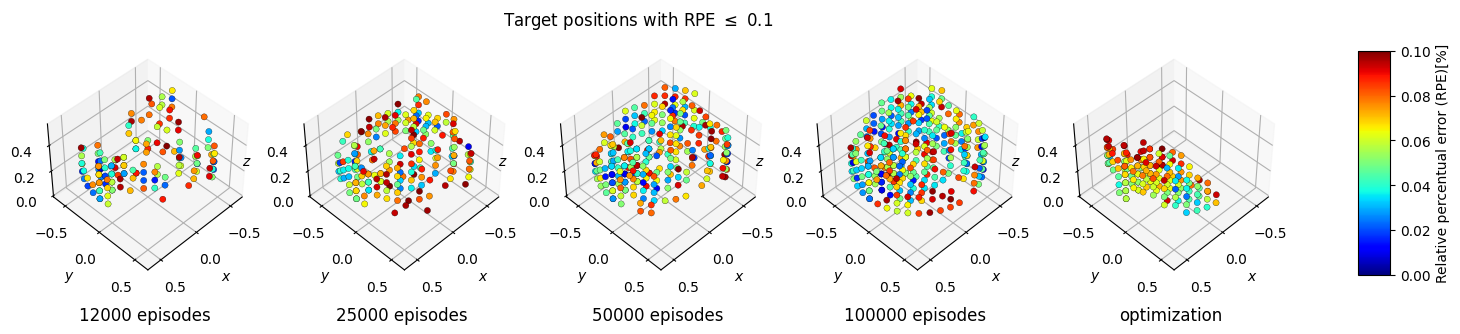

In [25]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# fig = plt.figure(figsize=(10,10))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values

    tests_error.append(perc_error)
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)    


    ax = fig.add_subplot(1, len(tests), i+1, projection='3d')
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.65, .65)
    ax.set_ylim(-.65, .65)
    ax.set_zlim(0, .55)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    ax.view_init(azim=45,elev=45)
    feasible_plot = ax.scatter(feasible_region[:, 0], feasible_region[:, 1], feasible_region[:, 2],
                                    c=err_filter, alpha=1, edgecolors="black", linewidths=0.2,
                                    cmap=cmap, norm=norm)
    
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-35)
    else:
        ax.set_title( 'optimization', y=.0, pad=-35)
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(feasible_plot, shrink=0.3, label='Relative percentual error (RPE)[%]', cax=cbar_ax)
fig.suptitle('Target positions with RPE $\leq$ 0.1')
plt.show()
fig.savefig(os.path.join('plots', f'feasible_filtered.png'), dpi=500)

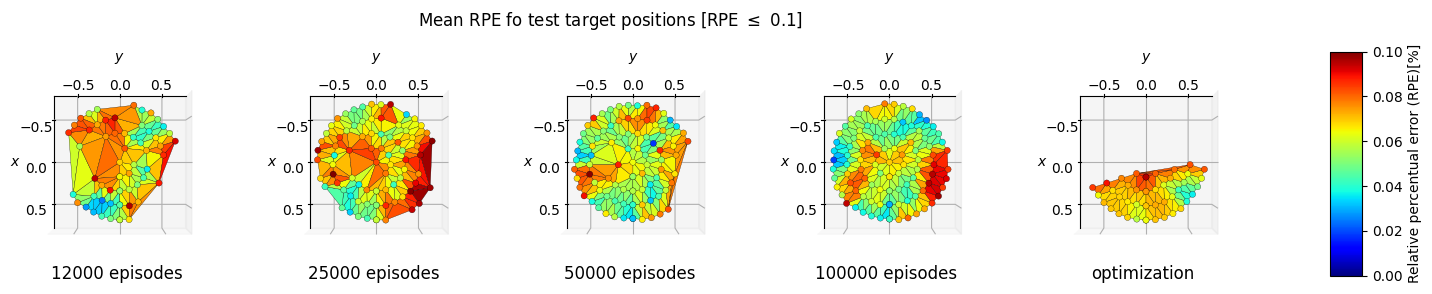

In [26]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# fig = plt.figure(figsize=(10,10))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values

    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)    


    # generate surface
    xy_pair = []
    err = []

    for j,p in enumerate(feasible_region):
        # new point
        if [p[0],p[1]] not in xy_pair:
            xy_pair.append([p[0],p[1]])
            err.append([err_filter[j]])
        else:
            # x,y present, get if z > z in array
            idx = xy_pair.index([p[0],p[1]])
            err[idx].append(err_filter[j])

    mean_err = [np.mean(e) for e in err]
    surface = np.append(np.array(xy_pair),np.array(mean_err).reshape(-1,1),axis=1)

    ax = fig.add_subplot(1, len(tests), i+1, projection='3d')
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.75, .75)
    ax.set_ylim(-.75, .75)
    ax.set_zlim(0, .1)
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.view_init(azim=0,elev=90)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-5)
    else:
        ax.set_title( 'optimization', y=.0, pad=-5)
    surf_plot = ax.plot_trisurf(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, cmap=cmap, norm=norm)
    surf_plot = ax.scatter(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, c=surface[:, 2], cmap=cmap, norm=norm)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(surf_plot, shrink=0.3, label='Relative percentual error (RPE)[%]', cax=cbar_ax)

fig.suptitle('Mean RPE fo test target positions [RPE $\leq$ 0.1]')
plt.show()
fig.savefig(os.path.join('plots', f'avg_mean_surface_plot.png'), dpi=500)

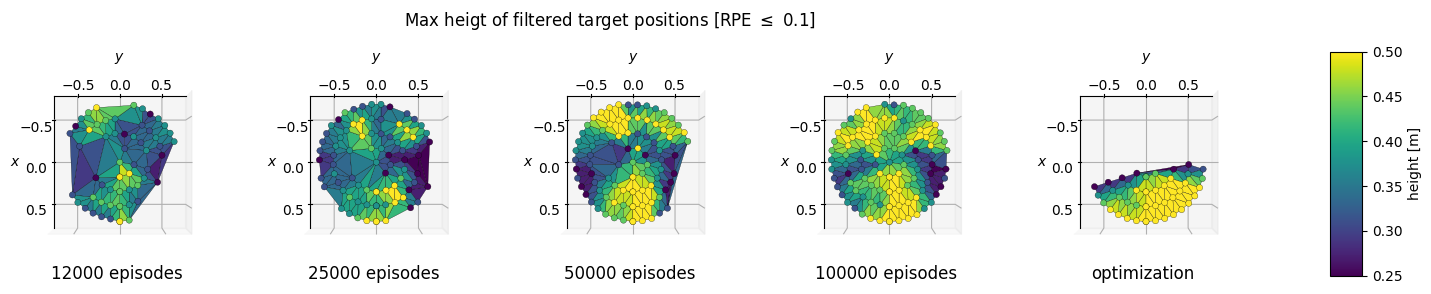

In [27]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))
# fig = plt.figure(figsize=(10,10))

for i,test in enumerate(tests):
    if test != 'optim':
        rb = joblib.load(
                f'../runs/test/model_{test}/ReplayBuffer_test.joblib')

        n_episode = rb.mem_size
        com0_points = rb.state[:n_episode][:, :3]
        target_points = rb.state[:n_episode][:, 3:]
        reached_points = rb.next_state[:n_episode][:, :3]
        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    else:
        target_points = np.array([target for target in optim['target_points'].values])
        perc_error = optim['error_log'].values
        
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)  

    # generate surface
    xy_pair = []
    max_z = []

    for p in feasible_region:
        # new point
        if [p[0],p[1]] not in xy_pair:
            xy_pair.append([p[0],p[1]])
            max_z.append(p[2])
        else:
            # x,y present, get if z > z in array
            idx = xy_pair.index([p[0],p[1]])
            if p[2] > max_z[idx]:
                # new z value
                max_z[idx] = p[2]

    surface = np.append(np.array(xy_pair),np.array(max_z).reshape(-1,1),axis=1)

    ax = fig.add_subplot(1, len(tests), i+1, projection='3d')
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.75, .75)
    ax.set_ylim(-.75, .75)
    ax.set_zlim(0, .55)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.view_init(azim=0,elev=90)
    if test != 'optim':
        ax.set_title( f'{test} episodes', y=.0, pad=-5)
    else:
        ax.set_title( 'optimization', y=.0, pad=-5)
    surf_plot = ax.plot_trisurf(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, cmap=z_cmap, norm=z_norm)
    surf_plot = ax.scatter(surface[:, 0], surface[:, 1], surface[:, 2], alpha=1, edgecolors="black", linewidths=0.2, c=surface[:, 2], cmap=z_cmap, norm=z_norm)
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
fig.colorbar(surf_plot, shrink=0.3 ,label='height [m]', cax=cbar_ax)

fig.suptitle('Max heigt of filtered target positions [RPE $\leq$ 0.1]')
plt.show()
fig.savefig(os.path.join('plots', f'surface_plot.png'), dpi=500)

In [28]:
tests_error = np.array(tests_error)

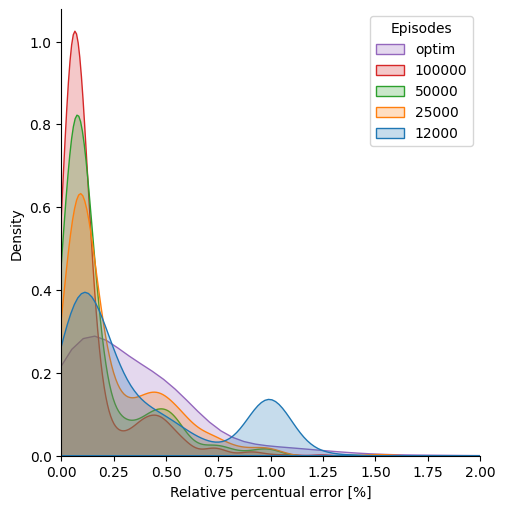

In [29]:
sns.displot([e for e in tests_error],kind='kde',fill=True,legend=False)
plt.legend(title="Episodes",labels=tests[::-1])
plt.xlim(0,2)
plt.savefig('err_dist.jpg',dpi=200)
plt.xlabel("Relative percentual error [%]")
plt.savefig(os.path.join('plots', 'error_density.png'), dpi=500)

In [30]:
tests_error.shape

(5, 505)

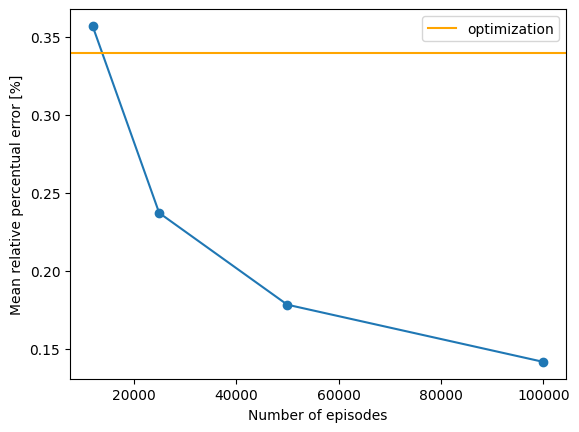

In [31]:
plt.plot(tests[:-1],np.mean(tests_error[:-1,:],axis=1))
plt.scatter(tests[:-1],np.mean(tests_error[:-1,:],axis=1))
plt.axhline(np.mean(tests_error[-1,:]),color='orange',label='optimization')
plt.xlabel('Number of episodes')
plt.ylabel('Mean relative percentual error [%]')
plt.legend()
plt.savefig(os.path.join('plots', 'avg_error.png'), dpi=500)